In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/My Drive/

/gdrive/My Drive/Tesi


In [ ]:
!pip install visualkeras
import visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 12.5 MB/s eta 0:00:00


In [ ]:
import random
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import warnings
import logging
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.12.0


In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
miss_rate = 0.3
batch_size = 100
hint_rate = 0.9
alpha = 100
iterations = 10000
epochs = 200
learning_rate = 5e-5

In [ ]:
def binary_sampler(p, rows, cols):
  '''Sample binary random variables.
  
  Args:
    - p: probability of 1
    - rows: the number of rows
    - cols: the number of columns
    
  Returns:
    - binary_random_matrix: generated binary random matrix.
  '''
  unif_random_matrix = np.random.uniform(0., 1., size = [rows, cols])
  binary_random_matrix = 1*(unif_random_matrix < p)
  return binary_random_matrix

In [ ]:
data_x = pd.read_csv("letter.csv")  #original data
no = data_x.shape[0]
dim = data_x.shape[1]
data_x

,Cat 1,Cat 2,Cat 3,Cat 4,Cat 5,Cat 6,Cat 7,Cat 8,Cat 9,Cat 10,Cat 11,Cat 12,Cat 13,Cat 14,Cat 15,Cat 16
0,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,2,2,3,3,2,7,7,7,6,6,6,4,2,8,3,7
19996,7,10,8,8,4,4,8,6,9,12,9,13,2,9,3,7
19997,6,9,6,7,5,6,11,3,7,11,9,5,2,12,2,4
19998,2,3,4,2,1,8,7,2,6,10,6,8,1,9,5,8


In [ ]:
data_m = binary_sampler(1-miss_rate, no, dim)   #indicator matrix for missing components
miss_data_x = data_x.copy()
miss_data_x[data_m == 0] = np.nan               #data with missing values
miss_data_x

,Cat 1,Cat 2,Cat 3,Cat 4,Cat 5,Cat 6,Cat 7,Cat 8,Cat 9,Cat 10,Cat 11,Cat 12,Cat 13,Cat 14,Cat 15,Cat 16
0,2.0,NaN,NaN,5.0,1.0,8.0,13.0,NaN,6.0,NaN,10.0,NaN,NaN,8.0,0.0,8.0
1,5.0,12.0,3.0,7.0,2.0,10.0,5.0,5.0,4.0,NaN,3.0,9.0,2.0,8.0,4.0,10.0
2,4.0,NaN,NaN,NaN,6.0,10.0,6.0,2.0,6.0,10.0,3.0,NaN,3.0,7.0,3.0,9.0
3,7.0,11.0,NaN,NaN,NaN,NaN,9.0,NaN,6.0,4.0,4.0,10.0,6.0,10.0,NaN,8.0
4,2.0,1.0,3.0,NaN,1.0,NaN,NaN,6.0,6.0,NaN,NaN,NaN,NaN,7.0,5.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,2.0,2.0,NaN,3.0,2.0,NaN,7.0,7.0,NaN,NaN,6.0,4.0,2.0,8.0,3.0,7.0
19996,NaN,10.0,8.0,8.0,4.0,NaN,NaN,6.0,9.0,NaN,NaN,13.0,2.0,9.0,3.0,7.0
19997,NaN,9.0,NaN,7.0,5.0,NaN,NaN,3.0,NaN,11.0,9.0,NaN,2.0,NaN,2.0,4.0
19998,2.0,3.0,4.0,2.0,1.0,8.0,7.0,2.0,6.0,NaN,6.0,8.0,NaN,9.0,5.0,8.0


In [ ]:
h_dim = int(dim)          #latent dimension, z 
scaler = MinMaxScaler()
norm_data = scaler.fit_transform(miss_data_x)
norm_data_x = np.nan_to_num(norm_data, 0)
norm_data_x

array([[0.13333333, 0.        , 0.        , ..., 0.5       , 0.        ,
        0.53333333],
       [0.33333333, 0.8       , 0.2       , ..., 0.5       , 0.26666667,
        0.66666667],
       [0.26666667, 0.        , 0.        , ..., 0.42857143, 0.2       ,
        0.6       ],
       ...,
       [0.        , 0.6       , 0.        , ..., 0.        , 0.13333333,
        0.26666667],
       [0.13333333, 0.2       , 0.26666667, ..., 0.57142857, 0.33333333,
        0.53333333],
       [0.26666667, 0.6       , 0.4       , ..., 0.        , 0.13333333,
        0.53333333]])

In [ ]:
#input_shape = np.arange(6400).reshape(200, 32)
#input_shape = input_shape.shape
input = np.concatenate([norm_data_x, data_m], axis=1)
input_shape = input.shape[1:] 
input_shape

(32,)

In [ ]:
#db = DBSCAN(eps=0.25, min_samples=20).fit(norm_data_x)       #CLUSTERING
db = KMeans(n_clusters=4).fit_predict(norm_data_x)

In [ ]:
#print(set(db.labels_))
#l = list(db.labels_)
#l.count(0)
#set(db)

In [ ]:
df = pd.DataFrame(norm_data_x)
df['clustering'] = db
#df.loc[df['clustering'] == -1]

In [ ]:
dmask = pd.DataFrame(data_m)
dmask['clustering'] = db
data_x['clustering'] = db

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 32)]              0         
                                                                 
 Hidden1 (Dense)             (None, 64)                2112      
                                                                 
 Hidden2 (Dense)             (None, 128)               8320      
                                                                 
 Output (Dense)              (None, 16)                2064      
                                                                 
Total params: 12,496
Trainable params: 12,496
Non-trainable params: 0
_________________________________________________________________


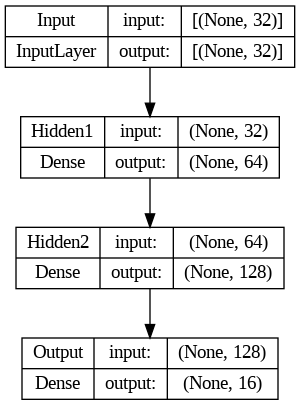

In [ ]:
def get_discriminator(input_shape, seed = seed):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    hidden_layer1 = tfkl.Dense(units=64, activation='relu', name='Hidden1', kernel_initializer=tfk.initializers.HeUniform(seed), kernel_regularizer=tfk.regularizers.L2(0.01))(input_layer)
    #x = tfkl.LeakyReLU(alpha=0.2, name='activation1')(hidden_layer1)
    #dropout1 = tfkl.Dropout(0.3, seed=seed)(x)
    hidden_layer2 = tfkl.Dense(units=128, activation='relu', name='Hidden2', kernel_initializer=tfk.initializers.HeUniform(seed), kernel_regularizer=tfk.regularizers.L2(0.01))(hidden_layer1)
    #x = tfkl.LeakyReLU(alpha=0.2, name='activation2')(hidden_layer2)
    #dropout2 = tfkl.Dropout(0.3, seed=seed)(x)
    output_layer = tfkl.Dense(units=16, activation='sigmoid', name='Output')(hidden_layer2)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='discriminator')

    # Return the model
    return model

discriminator = get_discriminator(input_shape)
discriminator.summary()
#display(visualkeras.layered_view(discriminator, legend=True, scale_xy=6))
tfk.utils.plot_model(discriminator, show_shapes=True, expand_nested=True)

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 32)]              0         
                                                                 
 Hidden1 (Dense)             (None, 64)                2112      
                                                                 
 Hidden2 (Dense)             (None, 128)               8320      
                                                                 
 Output (Dense)              (None, 16)                2064      
                                                                 
Total params: 12,496
Trainable params: 12,496
Non-trainable params: 0
_________________________________________________________________


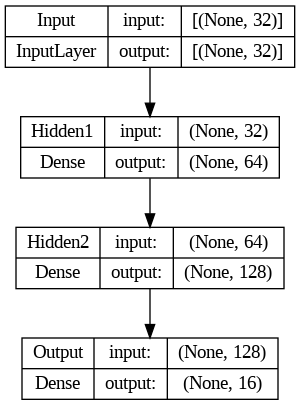

In [ ]:
def get_generator(input_shape, seed = seed):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    hidden_layer1 = tfkl.Dense(units=64, activation='relu', name='Hidden1', kernel_initializer=tfk.initializers.HeUniform(seed), kernel_regularizer=tfk.regularizers.L2(0.01))(input_layer)
    #x = tfkl.LeakyReLU(alpha=0.2, name='activation1')(hidden_layer1)
    #dropout1 = tfkl.Dropout(0.3, seed=seed)(x)
    hidden_layer2 = tfkl.Dense(units=128, activation='relu', name='Hidden2', kernel_initializer=tfk.initializers.HeUniform(seed), kernel_regularizer=tfk.regularizers.L2(0.01))(hidden_layer1)
    #x = tfkl.LeakyReLU(alpha=0.2, name='activation2')(hidden_layer2)
    #dropout2 = tfkl.Dropout(0.3, seed=seed)(x)
    output_layer = tfkl.Dense(units=16, activation='sigmoid', name='Output')(hidden_layer2)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='generator')

    # Return the model
    return model

generator = get_generator(input_shape)
generator.summary()
#display(visualkeras.layered_view(generator, legend=True, scale_xy=6))
tfk.utils.plot_model(generator, show_shapes=True, expand_nested=True)

In [ ]:
class GAN(tfk.Model):
    def __init__(self, discriminator, generator, h_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.h_dim = h_dim

        #self.loss_tracker = tfk.metrics.Mean(name="loss")
        self.mse_loss_tracker = tfk.metrics.Mean(name="mse_loss")
        self.d_loss_tracker = tfk.metrics.Mean(name="d_loss")
        self.g_loss_tracker = tfk.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer

    @property
    def metrics(self):
        return [
            #self.loss_tracker,
            self.mse_loss_tracker,
            self.d_loss_tracker,
            self.g_loss_tracker
        ]

    @tf.function
    def train_step(self, data):
        # Sample random points in the latent space
        x, m = data
        #print(x.shape)
        x = tf.cast(x, tf.float32)
        m = tf.cast(m, tf.float32)
        #batch_size = tf.shape(x)[0]
        #num_rows, num_cols = x.get_shape().as_list()
        #print(m.shape)
        #print(x, y)
        #m = tf.ones(shape = (200, 16))
        #m = np.copy(x)
        #m = tf.convert_to_tensor(m)
        #m[m != 0] = 1
        z = np.random.uniform(0, 0.01, size = [batch_size, h_dim])
        #z = tf.random.normal(shape=(batch_size, self.latent_dim))
        h_temp = binary_sampler(hint_rate, batch_size, h_dim)
        h = m * h_temp
        x = m * x + (1-m) * z 

        # Generate fake data from z
        input_g = tf.concat(values = [x, m], axis = 1) 
        #input_g = tf.reshape(input_g, (10, 200, 32, 1))
        #print(input_g.shape)
        g_sample = self.generator(input_g)
        #print(g_sample.shape)

        # Impute the generated data where the data is missing
        hat_x = x * m + g_sample * (1-m)

        # Train the discriminator
        with tf.GradientTape() as tape:
            input_d = tf.concat(values = [hat_x, h], axis = 1) 
            d_prob = self.discriminator(input_d)
            d_loss = -tf.reduce_mean(m * tf.math.log(d_prob + 1e-8) + (1-m) * tf.math.log(1. - d_prob + 1e-8))
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        #mse_loss = tf.reduce_mean((m * x - m * g_sample)**2) / tf.reduce_mean(m)

        # Sample random points in the latent space
        #z = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Create misleading labels for fake images so that they correspond to class 1
        #misleading_labels = tf.ones((batch_size, 1))

        # Train the generator 
        with tf.GradientTape() as tape:
            g_sample = self.generator(input_g)
            hat_x = x * m + g_sample * (1-m)
            d_prob = self.discriminator(input_d)
            d_loss = -tf.reduce_mean(m * tf.math.log(d_prob + 1e-8) + (1-m) * tf.math.log(1. - d_prob + 1e-8))
            g_loss_temp = -tf.reduce_mean((1-m) * tf.math.log(d_prob + 1e-8))
            mse_loss = tf.reduce_mean((m * x - m * g_sample)**2) / tf.reduce_mean(m)
            g_loss = g_loss_temp + alpha * mse_loss 
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        #loss += g_loss

        # Update metrics
        #self.loss_tracker.update_state(loss)
        self.mse_loss_tracker.update_state(mse_loss)
        self.d_loss_tracker.update_state(d_loss)
        self.g_loss_tracker.update_state(g_loss)
        return {
            #"loss": self.loss_tracker.result(),
            "mse_loss": self.mse_loss_tracker.result(),
            "d_loss": self.d_loss_tracker.result(),
            "g_loss": self.g_loss_tracker.result(),
        }

In [ ]:
data = []
mask = []
orig = []

for k in set(db):
  data.append(df.loc[df['clustering'] == k].drop(columns=['clustering']))
  mask.append(dmask.loc[dmask['clustering'] == k].drop(columns=['clustering']))
  orig.append(data_x.loc[data_x['clustering'] == k].drop(columns=['clustering']))

cluster 0
Epoch 1/200
47/47 - 5s - mse_loss: 0.0737 - d_loss: 0.8600 - g_loss: 7.5978 - 5s/epoch - 104ms/step
Epoch 2/200
47/47 - 0s - mse_loss: 0.0531 - d_loss: 0.7585 - g_loss: 5.5043 - 239ms/epoch - 5ms/step
Epoch 3/200
47/47 - 0s - mse_loss: 0.0396 - d_loss: 0.6835 - g_loss: 4.1275 - 208ms/epoch - 4ms/step
Epoch 4/200
47/47 - 0s - mse_loss: 0.0320 - d_loss: 0.6289 - g_loss: 3.3503 - 280ms/epoch - 6ms/step
Epoch 5/200
47/47 - 0s - mse_loss: 0.0281 - d_loss: 0.5884 - g_loss: 2.9459 - 322ms/epoch - 7ms/step
Epoch 6/200
47/47 - 0s - mse_loss: 0.0262 - d_loss: 0.5600 - g_loss: 2.7396 - 232ms/epoch - 5ms/step
Epoch 7/200
47/47 - 0s - mse_loss: 0.0251 - d_loss: 0.5398 - g_loss: 2.6227 - 236ms/epoch - 5ms/step
Epoch 8/200
47/47 - 0s - mse_loss: 0.0243 - d_loss: 0.5231 - g_loss: 2.5425 - 270ms/epoch - 6ms/step
Epoch 9/200
47/47 - 0s - mse_loss: 0.0237 - d_loss: 0.5085 - g_loss: 2.4783 - 218ms/epoch - 5ms/step
Epoch 10/200
47/47 - 0s - mse_loss: 0.0232 - d_loss: 0.4968 - g_loss: 2.4239 - 238

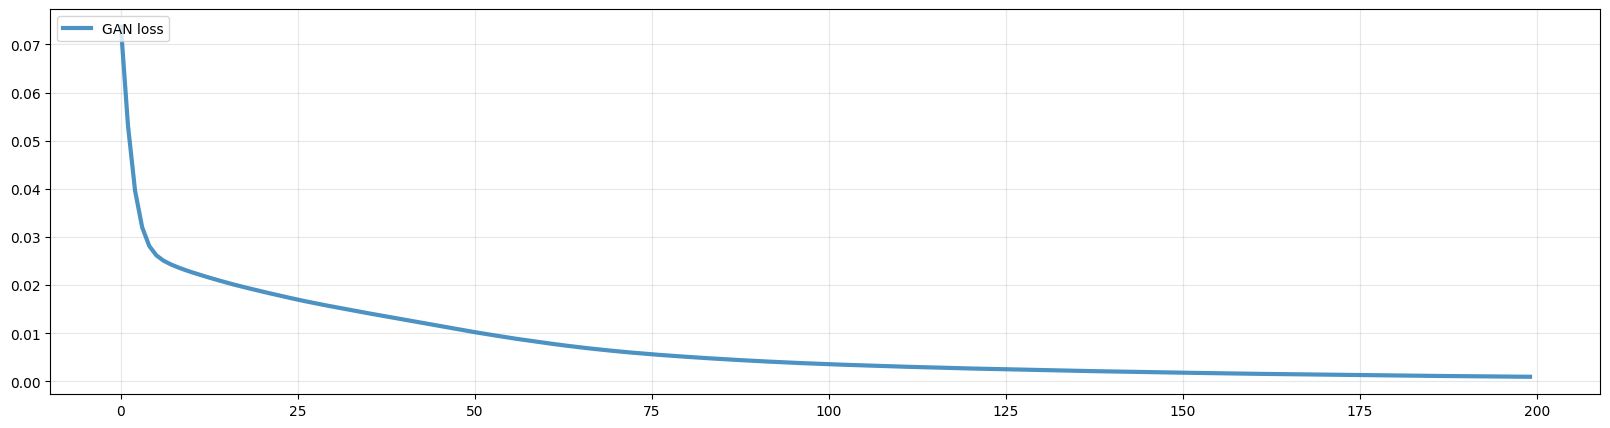

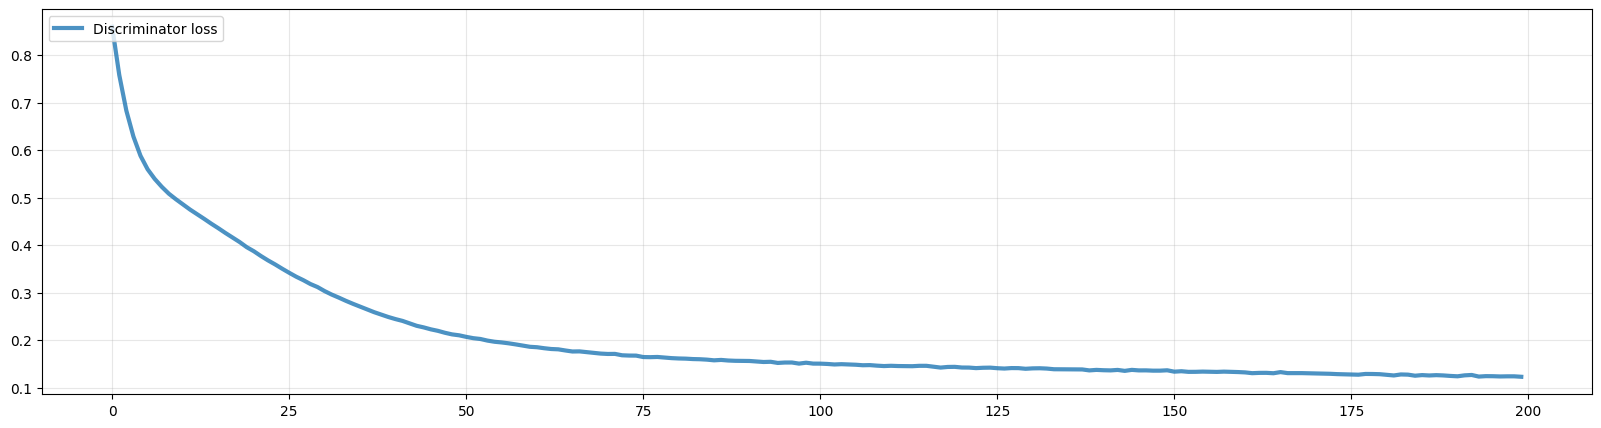

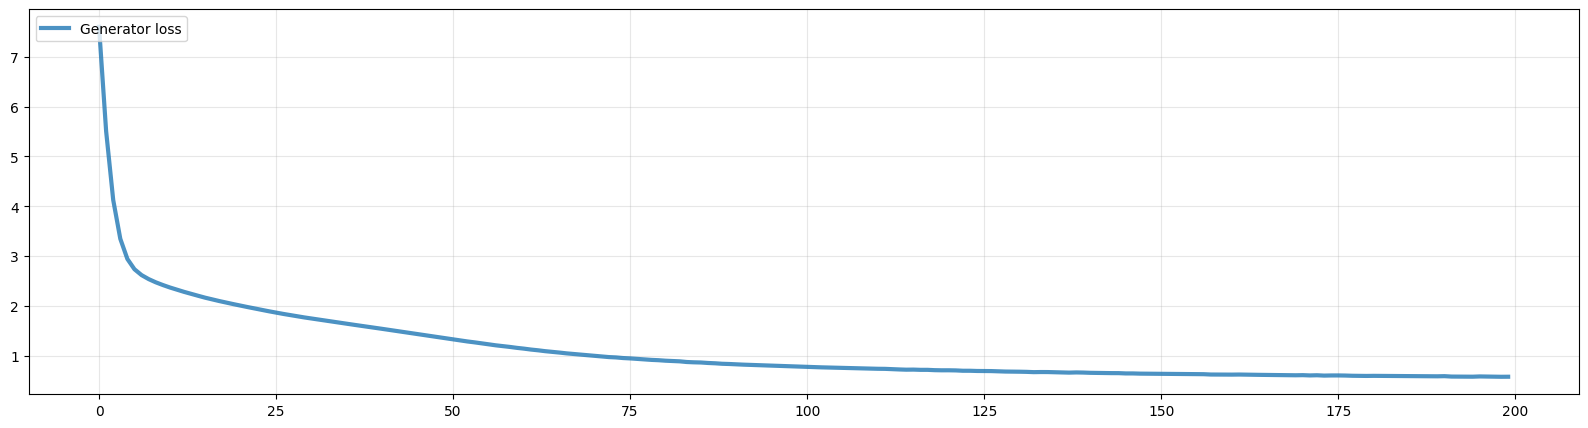

cluster 1
Epoch 1/200
41/41 - 4s - mse_loss: 0.0689 - d_loss: 0.8671 - g_loss: 7.1379 - 4s/epoch - 86ms/step
Epoch 2/200
41/41 - 0s - mse_loss: 0.0527 - d_loss: 0.7950 - g_loss: 5.4987 - 235ms/epoch - 6ms/step
Epoch 3/200
41/41 - 0s - mse_loss: 0.0420 - d_loss: 0.7365 - g_loss: 4.4124 - 286ms/epoch - 7ms/step
Epoch 4/200
41/41 - 0s - mse_loss: 0.0352 - d_loss: 0.6904 - g_loss: 3.7289 - 189ms/epoch - 5ms/step
Epoch 5/200
41/41 - 0s - mse_loss: 0.0311 - d_loss: 0.6529 - g_loss: 3.3177 - 197ms/epoch - 5ms/step
Epoch 6/200
41/41 - 0s - mse_loss: 0.0288 - d_loss: 0.6213 - g_loss: 3.0766 - 110ms/epoch - 3ms/step
Epoch 7/200
41/41 - 0s - mse_loss: 0.0273 - d_loss: 0.5935 - g_loss: 2.9339 - 113ms/epoch - 3ms/step
Epoch 8/200
41/41 - 0s - mse_loss: 0.0264 - d_loss: 0.5709 - g_loss: 2.8428 - 113ms/epoch - 3ms/step
Epoch 9/200
41/41 - 0s - mse_loss: 0.0257 - d_loss: 0.5526 - g_loss: 2.7782 - 116ms/epoch - 3ms/step
Epoch 10/200
41/41 - 0s - mse_loss: 0.0251 - d_loss: 0.5357 - g_loss: 2.7291 - 114m

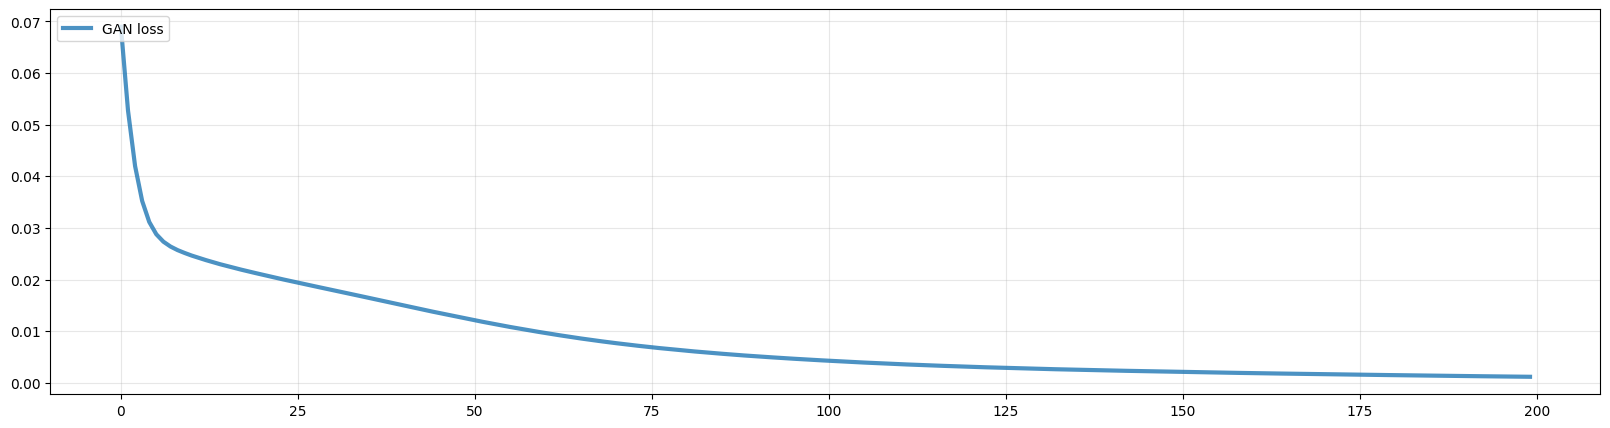

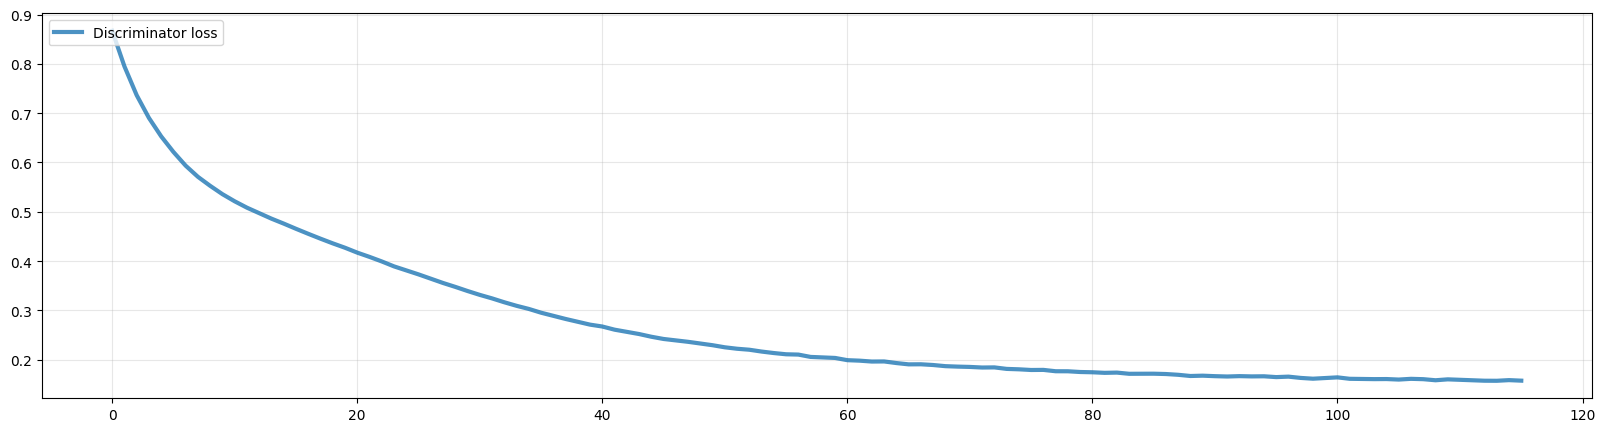

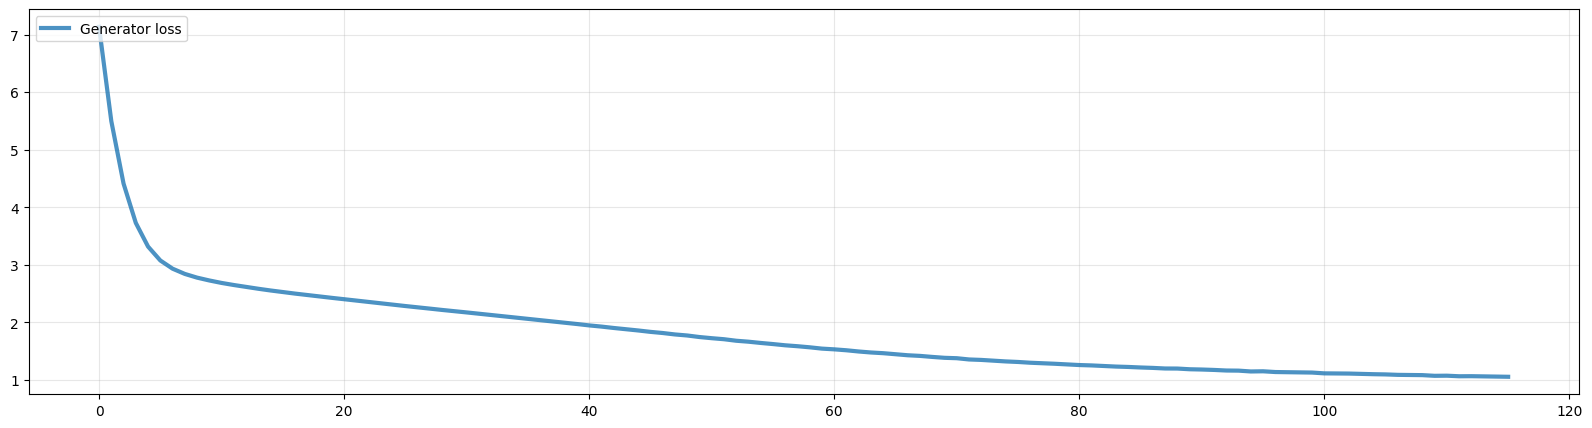

cluster 2
Epoch 1/200
55/55 - 2s - mse_loss: 0.0771 - d_loss: 0.7439 - g_loss: 7.9528 - 2s/epoch - 29ms/step
Epoch 2/200
55/55 - 0s - mse_loss: 0.0567 - d_loss: 0.6840 - g_loss: 5.9032 - 144ms/epoch - 3ms/step
Epoch 3/200
55/55 - 0s - mse_loss: 0.0438 - d_loss: 0.6444 - g_loss: 4.6156 - 159ms/epoch - 3ms/step
Epoch 4/200
55/55 - 0s - mse_loss: 0.0363 - d_loss: 0.6149 - g_loss: 3.8715 - 169ms/epoch - 3ms/step
Epoch 5/200
55/55 - 0s - mse_loss: 0.0322 - d_loss: 0.5929 - g_loss: 3.4643 - 145ms/epoch - 3ms/step
Epoch 6/200
55/55 - 0s - mse_loss: 0.0298 - d_loss: 0.5750 - g_loss: 3.2380 - 150ms/epoch - 3ms/step
Epoch 7/200
55/55 - 0s - mse_loss: 0.0284 - d_loss: 0.5588 - g_loss: 3.1014 - 153ms/epoch - 3ms/step
Epoch 8/200
55/55 - 0s - mse_loss: 0.0273 - d_loss: 0.5445 - g_loss: 3.0053 - 149ms/epoch - 3ms/step
Epoch 9/200
55/55 - 0s - mse_loss: 0.0264 - d_loss: 0.5305 - g_loss: 2.9317 - 150ms/epoch - 3ms/step
Epoch 10/200
55/55 - 0s - mse_loss: 0.0257 - d_loss: 0.5160 - g_loss: 2.8705 - 157m

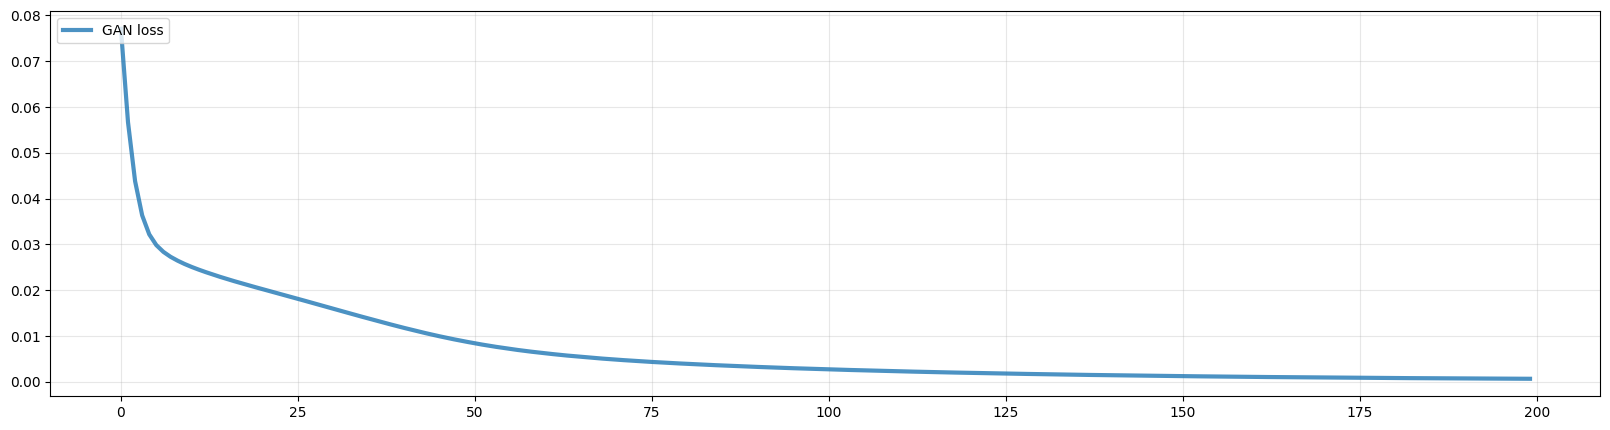

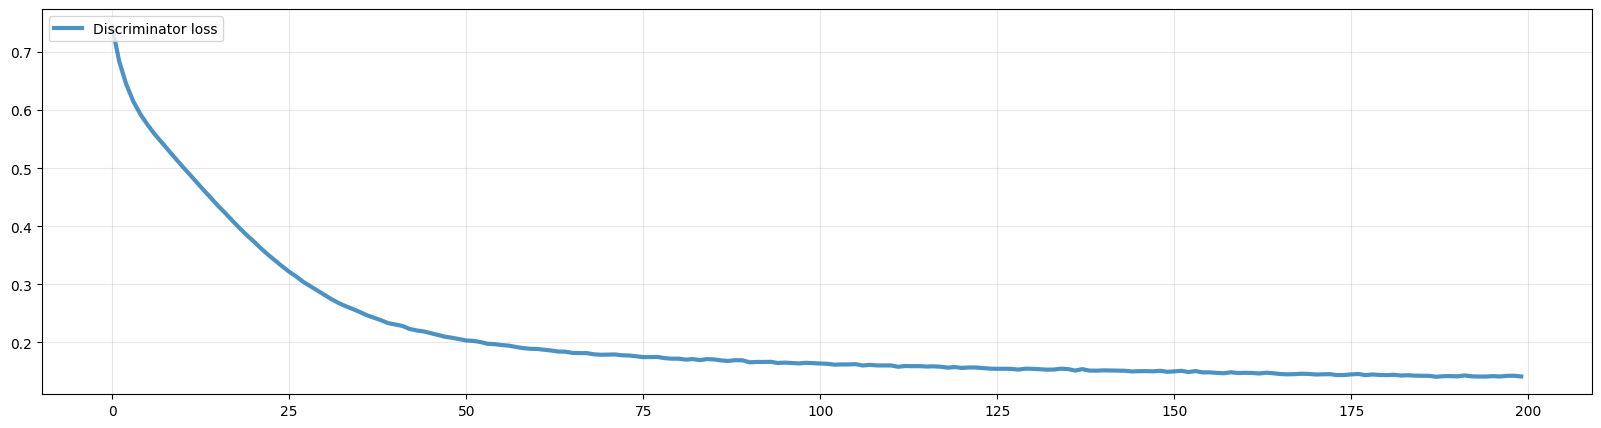

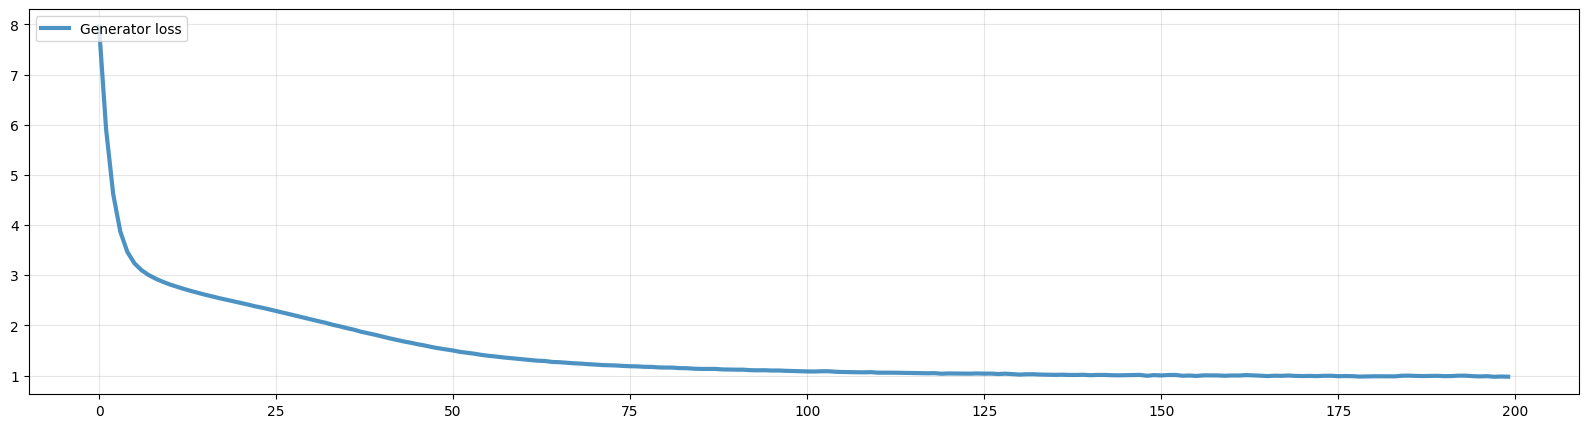

cluster 3
Epoch 1/200
55/55 - 2s - mse_loss: 0.0796 - d_loss: 0.7473 - g_loss: 8.1778 - 2s/epoch - 29ms/step
Epoch 2/200
55/55 - 0s - mse_loss: 0.0567 - d_loss: 0.6740 - g_loss: 5.8593 - 168ms/epoch - 3ms/step
Epoch 3/200
55/55 - 0s - mse_loss: 0.0411 - d_loss: 0.6226 - g_loss: 4.2757 - 168ms/epoch - 3ms/step
Epoch 4/200
55/55 - 0s - mse_loss: 0.0322 - d_loss: 0.5864 - g_loss: 3.3754 - 149ms/epoch - 3ms/step
Epoch 5/200
55/55 - 0s - mse_loss: 0.0281 - d_loss: 0.5604 - g_loss: 2.9524 - 160ms/epoch - 3ms/step
Epoch 6/200
55/55 - 0s - mse_loss: 0.0261 - d_loss: 0.5408 - g_loss: 2.7522 - 178ms/epoch - 3ms/step
Epoch 7/200
55/55 - 0s - mse_loss: 0.0250 - d_loss: 0.5240 - g_loss: 2.6356 - 159ms/epoch - 3ms/step
Epoch 8/200
55/55 - 0s - mse_loss: 0.0241 - d_loss: 0.5094 - g_loss: 2.5526 - 173ms/epoch - 3ms/step
Epoch 9/200
55/55 - 0s - mse_loss: 0.0234 - d_loss: 0.4954 - g_loss: 2.4865 - 182ms/epoch - 3ms/step
Epoch 10/200
55/55 - 0s - mse_loss: 0.0228 - d_loss: 0.4822 - g_loss: 2.4268 - 156m

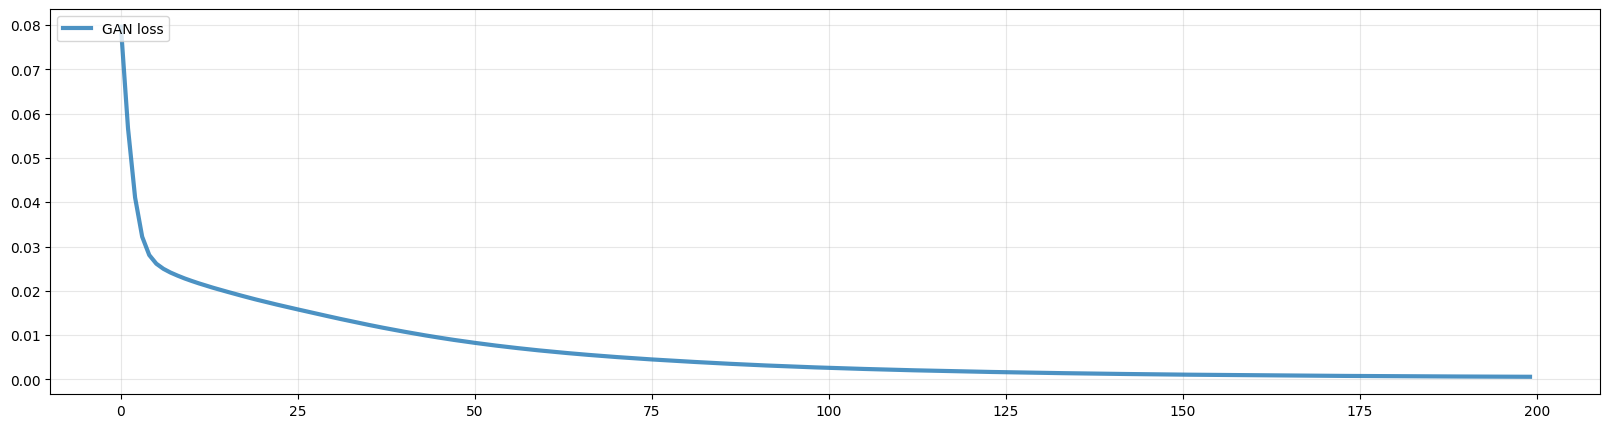

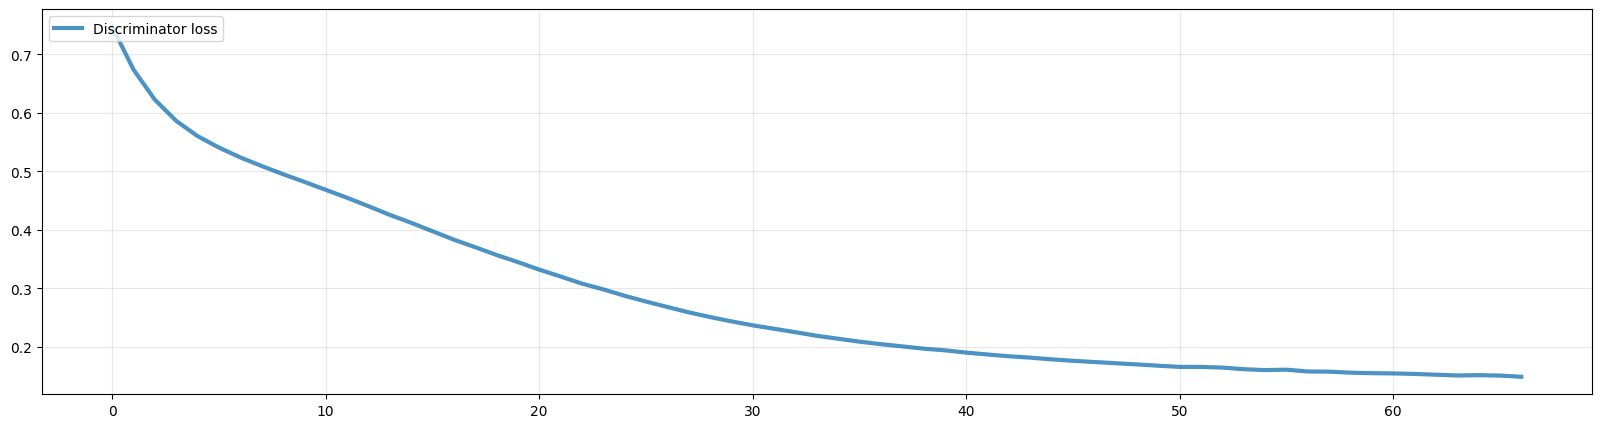

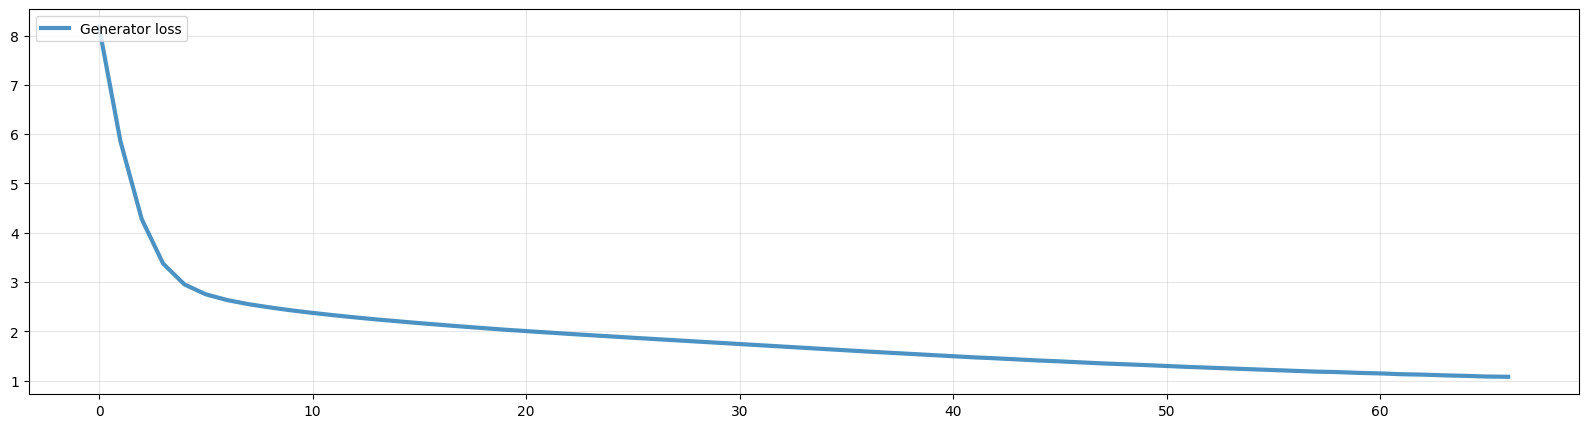

In [ ]:
for k in set(db):
  print('cluster ' + str(k))
  #data = df.loc[df['clustering'] == k].drop(columns=['clustering'])
  #mask = dmask.loc[df['clustering'] == k].drop(columns=['clustering'])
  input_d = data[k]
  input_m = mask[k]
  while (input_d.shape[0] % batch_size) != 0:
    input_d = input_d.drop(index=input_d.index[-1])
    input_m = input_m.drop(index=input_m.index[-1])
    #print(input_d.shape[0])

  gan = GAN(
    discriminator = get_discriminator(input_shape), 
    generator = get_generator(input_shape), 
    h_dim = h_dim
  )
  gan.compile(
    d_optimizer = tfk.optimizers.Adam(learning_rate=learning_rate),
    g_optimizer = tfk.optimizers.Adam(learning_rate=learning_rate)
  )
  
  history = gan.fit(
    x = input_d.to_numpy(),
    y = input_m.to_numpy(),
    epochs = epochs, 
    batch_size = batch_size,
    #callbacks = [GANMonitor(name='vanilla', gray=True)],
    verbose = 2
  ).history
  gan.generator.save('gan_generator_cluster_' + str(k))

  # Plot the training
  plt.figure(figsize=(20,5))
  plt.plot(history['mse_loss'], label='GAN loss', alpha=.8, linewidth=3)
  plt.legend(loc='upper left')
  plt.grid(alpha=.3)

  plt.figure(figsize=(20,5))
  plt.plot(history['d_loss'], label='Discriminator loss', alpha=.8, linewidth=3)
  plt.legend(loc='upper left')
  plt.grid(alpha=.3)

  plt.figure(figsize=(20,5))
  plt.plot(history['g_loss'], label='Generator loss', alpha=.8, linewidth=3)
  plt.legend(loc='upper left')
  plt.grid(alpha=.3)
  plt.show()

In [ ]:
imputed_data = []
orig_data = []
nominator = 0
denominator = 0

for k in set(db):
  gan_generator = tfk.models.load_model('gan_generator_cluster_' + str(k))

  #data = df.loc[df['clustering'] == k].drop(columns=['clustering']).to_numpy()
  #mask = dmask.loc[df['clustering'] == k].drop(columns=['clustering']).to_numpy()
  #orig = data_x.loc[df['clustering'] == k].drop(columns=['clustering'])
  no = data[k].shape[0]

  Z = np.random.uniform(0, 0.01, size = [no, dim])
  M = mask[k].to_numpy()
  X = data[k].to_numpy()        
  X = M * X + (1-M) * Z

  input_g = tf.concat(values = [X, M], axis = 1) 
  imputed_data.append(gan_generator(input_g).numpy())
  #data = scaler.inverse_transform(imputed_data)
  #data = np.round(data)
  orig_data.append(scaler.fit_transform(orig[k]))

  nominator = nominator + np.sum(((1-M) * orig_data[k] - (1-M) * imputed_data[k])**2)
  denominator = denominator + np.sum(1-M)
  

rmse = np.sqrt(nominator/float(denominator))
print('rmse = ' + str(rmse))

rmse = 0.2325401094792412


In [ ]:
pd.DataFrame(orig_data[1])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.333333,0.733333,0.500000,0.571429,0.500000,0.666667,0.357143,0.133333,0.400000,0.583333,0.200000,0.428571,0.230769,0.416667,0.200000,0.615385
1,0.333333,0.133333,0.416667,0.285714,0.333333,0.533333,0.428571,0.400000,0.400000,0.333333,0.400000,0.357143,0.153846,0.500000,0.466667,0.692308
2,0.333333,0.600000,0.500000,0.500000,0.500000,0.466667,0.500000,0.400000,0.133333,0.250000,0.333333,0.714286,0.307692,0.500000,0.466667,0.538462
3,0.416667,0.600000,0.416667,0.500000,0.500000,0.400000,0.714286,0.466667,0.200000,0.333333,0.200000,0.571429,0.153846,0.416667,0.333333,0.769231
4,0.083333,0.200000,0.166667,0.142857,0.083333,0.533333,0.500000,0.133333,0.333333,0.916667,0.333333,0.500000,0.000000,0.416667,0.000000,0.461538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4133,0.583333,0.666667,0.416667,0.357143,0.166667,0.400000,0.714286,0.333333,0.266667,0.666667,0.600000,0.214286,0.307692,0.750000,0.200000,0.692308
4134,0.750000,1.000000,0.500000,0.571429,0.416667,0.333333,0.428571,0.466667,0.266667,0.583333,0.466667,0.642857,0.384615,0.583333,0.333333,0.538462
4135,0.250000,0.533333,0.416667,0.428571,0.416667,0.733333,0.714286,0.133333,0.133333,0.166667,0.533333,0.428571,0.538462,0.833333,0.066667,0.461538
4136,0.500000,0.600000,0.500000,0.500000,0.416667,0.400000,0.714286,0.200000,0.466667,0.666667,0.600000,0.285714,0.153846,0.833333,0.133333,0.230769


In [ ]:
pd.DataFrame(imputed_data[1])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.239436,0.299230,0.359420,0.292311,0.299274,0.668308,0.362097,0.139891,0.394223,0.674147,0.190156,0.274288,0.176601,0.426151,0.196905,0.607286
1,0.203373,0.176492,0.271281,0.220902,0.187623,0.516257,0.459978,0.401883,0.263789,0.450331,0.368780,0.245322,0.150315,0.475013,0.458883,0.659170
2,0.376686,0.603958,0.351345,0.483891,0.366295,0.423606,0.398931,0.290775,0.170562,0.410557,0.323424,0.250162,0.264359,0.512834,0.483805,0.530412
3,0.311652,0.626028,0.322206,0.502634,0.346704,0.435012,0.385556,0.499366,0.213915,0.495037,0.239592,0.275416,0.145942,0.454532,0.393312,0.690256
4,0.103129,0.223821,0.182077,0.154488,0.095446,0.427404,0.476821,0.142662,0.340120,0.886597,0.313273,0.241945,0.045193,0.431771,0.062068,0.477009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4133,0.384667,0.321581,0.379183,0.357698,0.141804,0.398447,0.444175,0.338839,0.227179,0.721038,0.622375,0.234948,0.185044,0.674695,0.171367,0.590614
4134,0.455664,0.325084,0.428426,0.492899,0.366460,0.404750,0.524850,0.401419,0.245611,0.675036,0.442770,0.302406,0.297635,0.282567,0.139320,0.233658
4135,0.330020,0.303464,0.383255,0.382252,0.311298,0.706781,0.663242,0.149752,0.117849,0.330483,0.328513,0.216165,0.546956,0.293362,0.110927,0.464564
4136,0.390133,0.594845,0.354179,0.444573,0.279659,0.361960,0.468005,0.183113,0.295809,0.754959,0.553753,0.358049,0.196533,0.310137,0.127865,0.363710


In [ ]:
mask[1]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
2,1,0,0,0,1,1,1,1,1,1,1,0,1,1,1,1
6,1,1,1,1,1,1,1,1,0,1,1,0,1,1,1,1
12,0,1,1,1,0,0,0,0,1,1,1,0,1,1,1,1
14,1,1,0,1,0,1,0,1,1,1,1,0,1,1,1,1
20,1,0,1,1,0,0,1,1,1,1,1,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19983,1,0,1,1,1,1,0,1,0,1,1,0,1,1,1,1
19986,0,0,0,1,1,0,1,0,1,1,1,0,1,0,0,0
19990,0,0,1,1,1,1,1,1,1,1,0,0,1,0,1,1
19997,0,1,0,1,1,0,0,1,0,1,1,0,1,0,1,1
